## Here we will investigate some potential features for our model

For each feature we will create a resource where by we can look up on location (geohash) so we can do this for unseen data points..

##### 1. Number of violations at the address

A simple feature to use is the number of incidents from 'detroit-blight-violations.csv' at the building

In [3]:
# Load the building definitions file:
import json
from blight_functions.unique_buildings import unique_buildings
    
buildings = unique_buildings('data/unique_buildings.json')

In [4]:
import pandas as pd

# Read in violations
blight_violations = pd.read_csv('data/detroit-blight-violations.csv', delimiter=',', na_values=['', 'N/A'])

# Parse locations & Add another column to our demolition_permits to join
blight_violations['geohashed'] = blight_violations.apply(lambda row: buildings.location_to_building(row['ViolationAddress']), axis=1)

C:\Python27\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Group by geohash
blight_violations_grouped = blight_violations.groupby(['geohashed']).size()

# How many errors ? 
blight_violations.groupby(['geohashed']).size()[:5]

geohashed
MAX_ADDR_PER_BUILDING    39475
dpsb7mxqzt1r                 1
dpsb7mz4z2e3                 2
dpsb7qp2sjm5                 2
dpsb7qp3js3u                 1
dtype: int64

In [6]:
# Remove the error lines
blight_violations_grouped.pop('MAX_ADDR_PER_BUILDING')
'{} distinct geohashes out of {} incidents'.format(len(blight_violations_grouped), len(blight_violations))

'96086 distinct geohashes out of 307804 incidents'

In [7]:
# Save the results to a csv file - [geohash, number of violations]
blight_violations_grouped.to_csv('data/features/violations_at_address.csv')

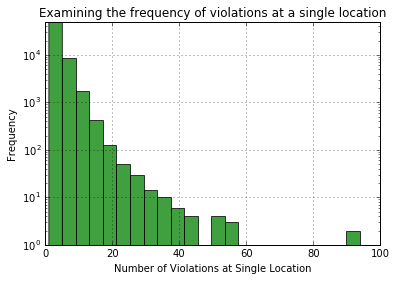

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(blight_violations_grouped, 50, facecolor='green', alpha=0.75)

plt.xlabel('Number of Violations at Single Location')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title(r'Examining the frequency of violations at a single location')
plt.axis([0, 100, 0, 50000])
plt.grid(True)

plt.show()

##### 2. Proximity to crimes

For proximity, since we have applied geohash we can simply remove characters from the end of the hash to increase the bounding box. Whilst this will return a square(ish) region, and so is not true proximity, it is a reasonable estimation to make for the decrease in computational complexity.

Approximately the number of characters in the hash gives a distance accurate to, accurate at the equator and approximately right in Detroit:

| Characters | Precision in km |
|------------|-----------------|
| 1          | ±2500           |
| 2          | ±630            |
| 3          | ±78             |
| 4          | ±20             |
| 5          | ±2.4            |
| 6          | ±0.61           |
| 7          | ±0.076          |
| 8          | ±0.019          |
| 9          | ±0.0024         |
| 10         | ±0.00060        |
| 11         | ±0.000074       |
| 12         | ±0.0000185      |

A reasonable proximity to look at would be a bounding box of 1km, this is roughly equivalent to truncating geohashes at 6 characters.

In reality crimes have differing degrees of seriousness, however for this feature I am going to simply treat all crimes as equal.

In [28]:
# Read in crimes
import pandas as pd
crime_incidents = pd.read_csv('data/detroit-crime.csv', delimiter=',', na_values=['', 'N/A'])

In [10]:
# Parse locations & Add another column to our demolition_permits to join
from blight_functions import location
crime_incidents['geohashed'] = crime_incidents.apply(lambda row: location.get_geohash(row['LOCATION'], precision=6), axis=1)

In [13]:
# Group by geohash
crime_incidents_grouped = crime_incidents.groupby(['geohashed']).size()
crime_incidents_grouped[:5]

geohashed
9mux5h    1
9q5yv7    1
9q9vyn    1
9q9zby    1
9qd94p    1
dtype: int64

In [24]:
# Save the results to a csv file - [geohash (shortend, number of crimes]
crime_incidents_grouped.to_csv('data/features/crimes_at_truncated_geohash.csv')

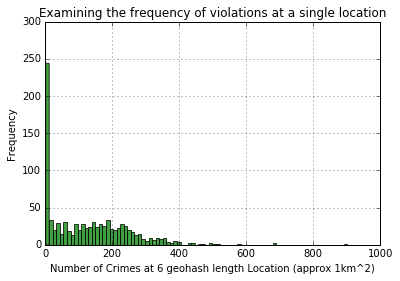

In [23]:
# Examine the distribution
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(crime_incidents_grouped, 100, facecolor='green', alpha=0.75)

plt.xlabel('Number of Crimes at 6 geohash length Location (approx 1km^2)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title(r'Examining the frequency of crimes at a single location')
plt.axis([0, 1000, 0, 300])
plt.grid(True)

plt.show()

##### 3. Proximity to other blighted buildings

The method here is very similar to looking at the proximity to crimes, except we will be comparing it to the labeled known 'blighted' buildings from earlier. My hypothesis is that the more blighted buildings in the area the higher the probability more in the area will become blighted in the future.

In [27]:
# Read in labelled data
import pandas as pd
labeled_data = pd.read_csv('data/training.csv', delimiter=',', na_values=['', 'N/A'])

# Select only the blighted geohashes
blighted_geohashes = labeled_data[labeled_data['is_blighted?']==True]

blighted_geohashes[:5]

,geohash,is_blighted?
2287,dpsckffh1325,True
2288,dpschpgnd8rd,True
2289,dpsby5bkz7wf,True
2290,dpsbuh3gprkp,True
2291,dpscq6ew1mzd,True


In [30]:
# Truncate geohash to 6 characters
blighted_geohashes_truncated = blighted_geohashes.copy()
blighted_geohashes_truncated['geohash'] = blighted_geohashes.apply(lambda row: row['geohash'][:6], axis=1)
blighted_geohashes_truncated[:5]

,geohash,is_blighted?
2287,dpsckf,True
2288,dpschp,True
2289,dpsby5,True
2290,dpsbuh,True
2291,dpscq6,True


In [33]:
# Group by geohash
blighted_geohashes_truncated_grouped = blighted_geohashes_truncated.groupby(['geohash']).size()
'{} precision 12 geohashes grouped up to {} precision 6 geohashes'.format(len(blighted_geohashes), 
                                                                          len(blighted_geohashes_truncated_grouped))

'2287 precision 12 geohashes grouped up to 501 precision 6 geohashes'

In [38]:
# Save the results to a csv file - [geohash (shortend, number of crimes]
blighted_geohashes_truncated_grouped.to_csv('data/features/blighted_buildings_at_truncated_geohash.csv')

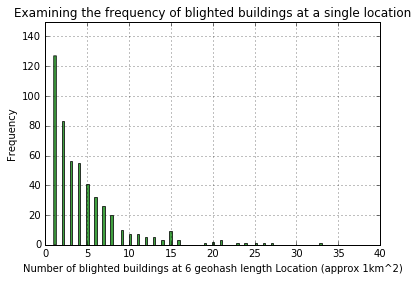

In [37]:
# Examine the distribution
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(blighted_geohashes_truncated_grouped, 100, facecolor='green', alpha=0.75)

plt.xlabel('Number of blighted buildings at 6 geohash length Location (approx 1km^2)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title(r'Examining the frequency of blighted buildings at a single location')
plt.axis([0, 40, 0, 150])
plt.grid(True)

plt.show()

##### 4. Proximity to blight incidents

Same as looking at proximity to labeled blighted buildings, and slightly different to looking (and perhaps more reliable in terms of available data) at blight incidents at the exact address, lets count the incidents of blight violations within the same approximate proximity. Again the hypothesis is that the more blight violations in the nearby area the more likely buildings in the same area are to become blighted.

In [39]:
import pandas as pd

# Read in violations
blight_violations = pd.read_csv('data/detroit-blight-violations.csv', delimiter=',', na_values=['', 'N/A'])

C:\Python27\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
# Parse locations & Add another column to our demolition_permits to join
from blight_functions import location
blight_violations['geohashed'] = blight_violations.apply(lambda row: location.get_geohash(row['ViolationAddress'], precision=6), 
                                                         axis=1)

In [43]:
# Group by geohash
blight_violations_grouped = blight_violations.groupby(['geohashed']).size()
blight_violations_grouped[:5]

geohashed
dpsb7m     3
dpsb7q    12
dpsb7s     4
dpsb7t    56
dpsb7w    74
dtype: int64

In [44]:
# Save the results to a csv file - [geohash (shortend, number of crimes]
blight_violations_grouped.to_csv('data/features/violations_at_truncated_geohash.csv')

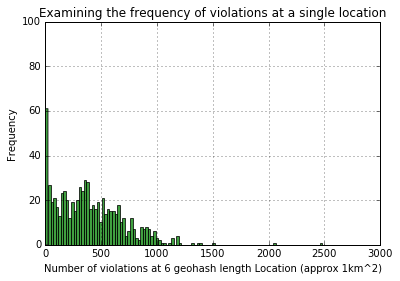

In [49]:
# Examine the distribution
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(blight_violations_grouped, 1000, facecolor='green', alpha=0.75)

plt.xlabel('Number of violations at 6 geohash length Location (approx 1km^2)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title(r'Examining the frequency of violations at a single location')
plt.axis([0, 3000, 0, 100])
plt.grid(True)

plt.show()

##### 5. Proximity to 311 calls 
Same again with 311 calls. Hypothesis is that the more calls in the area, the more likely buildings in the area are to become blighted.

In [29]:
import pandas as pd

# Read in 311 calls
calls_311 = pd.read_csv('data/detroit-311.csv', delimiter=',', na_values=['', 'N/A'])

In [52]:
# Parse locations & Add another column to our demolition_permits to join
from blight_functions import location
calls_311['geohashed'] = calls_311.apply(lambda row: location.get_geohash(row['location'], precision=6), axis=1)

In [53]:
# Group by geohash
calls_311_grouped = calls_311.groupby(['geohashed']).size()
calls_311_grouped[:5]

geohashed
dp6qq8     1
dpsb7q     2
dpsb7s     8
dpsb7t    32
dpsb7v     1
dtype: int64

In [54]:
# Save the results to a csv file - [geohash (shortend, number of crimes]
calls_311_grouped.to_csv('data/features/311_calls_at_truncated_geohash.csv')

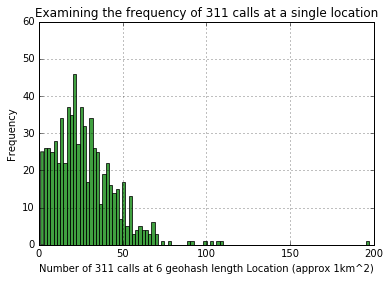

In [60]:
# Examine the distribution
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(calls_311_grouped, 200, facecolor='green', alpha=0.75)

plt.xlabel('Number of 311 calls at 6 geohash length Location (approx 1km^2)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title(r'Examining the frequency of 311 calls at a single location')
plt.axis([0, 200, 0, 60])
plt.grid(True)

plt.show()

##### 6. Any relevant building features ? 

If we had a another data source (e.g. census data) which could tell us more about the building and it's inhabitants we could use that to engineer some additional features.

For example:
- number of residents in building
- number 
- last move in date / last sale date
- number of stories
- average rental / market value of the propery